# Introduction to VAE's

Sources:
[Video Guide to VAE's](https://www.youtube.com/watch?v=9zKuYvjFFS8&ab_channel=ArxivInsights)

## What is an autoencoder?

> Takes a high-dimensional vector (image/other thing), and runs it through a neural net (could be a CNN/ simple MLP) in order to compress the vector, extracting important information.
> 'Bottleneck' is low-dimensional vector that we compress with our NN, and then try to reconstruct with our decoder

![Picture of normal autoencoder](autoencoder.png)

Parts:
1. Encoder: compresses the image (CNN/MLP) into a lower-dimensional space
2. Decoder: Reconstruct the image based on the compress image (latent space)
3. Training:
    - Compare original image with our reconstruction to compute loss
    - Simply do this: how much is overall pixel-difference?

> Intuition:
> Imagine we have completely random pixels, we will need every single pixels value in a vector to reconstruct it
> 
> However, real data has patterns, and if we can capture these complex patterns with neural nets, we can represent images in a lower-dimensional latent-space.
> 
> The lower number of dimensions we have, the less specific we can be about our image.



## Part 1. Simple Autoencoder With a Convultional NN

Our network should be able to learn:
1. How to effectively compress the most important information about our images
2. How to reconstruct these images as accurately as possible based on our latent space vector

Decoder architecture:
- 3 convolutional layers to take advantage of properties of images

Encoder architecture:
- 'Transposed' layers: do the reverse of what we did in the beginning to get the original image
- IE: if the last decoder layer was a nin,nout linear layer, the first decoder layer will be a nout,nin linear layer

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [2]:
# First, loading the data
transform = transforms.ToTensor() # converting to tensor
picture_data = datasets.STL10(root='../../data',split="train",download=True,transform=transform)

Files already downloaded and verified


In [3]:
images = [picture_data[i][0] for i in range(len(picture_data))]
images[0].shape # color, height, width

torch.Size([3, 96, 96])

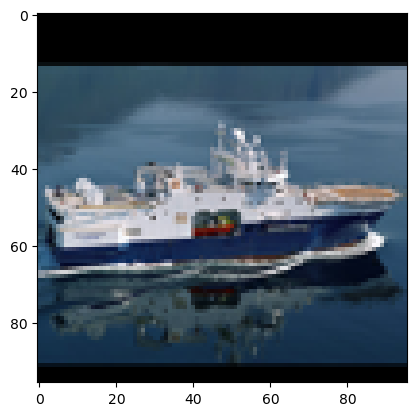

In [4]:
# permuting to work with imshow (H,W,C)
imgs_show = [image.permute(1,2,0) for image in images]
plt.imshow(imgs_show[9])

In [5]:
images[0] # values are between zero and one

tensor([[[0.5725, 0.5725, 0.5725,  ..., 0.6353, 0.6353, 0.6353],
         [0.5725, 0.5725, 0.5725,  ..., 0.6392, 0.6392, 0.6392],
         [0.5725, 0.5725, 0.5725,  ..., 0.6431, 0.6431, 0.6431],
         ...,
         [0.5098, 0.5176, 0.4588,  ..., 0.5373, 0.5882, 0.5529],
         [0.5255, 0.6078, 0.3451,  ..., 0.5294, 0.5333, 0.5373],
         [0.5294, 0.3804, 0.4549,  ..., 0.5412, 0.5765, 0.5412]],

        [[0.5608, 0.5608, 0.5608,  ..., 0.6235, 0.6235, 0.6235],
         [0.5608, 0.5608, 0.5608,  ..., 0.6196, 0.6196, 0.6196],
         [0.5608, 0.5608, 0.5608,  ..., 0.6196, 0.6196, 0.6196],
         ...,
         [0.4471, 0.4667, 0.4078,  ..., 0.5176, 0.5412, 0.4784],
         [0.4627, 0.5529, 0.2902,  ..., 0.5137, 0.4863, 0.4706],
         [0.4667, 0.3255, 0.4078,  ..., 0.4980, 0.5333, 0.5020]],

        [[0.4314, 0.4314, 0.4314,  ..., 0.4941, 0.4941, 0.4941],
         [0.4314, 0.4314, 0.4314,  ..., 0.4941, 0.4941, 0.4941],
         [0.4314, 0.4314, 0.4314,  ..., 0.4941, 0.4941, 0.

In [6]:
D1 = 96
D2 = 96 # dimensionality of data
import torch.nn as nn
# creating the MLP autoencoder
class AutoencoderMLP(nn.Module):
    def __init__(self):
        super(AutoencoderMLP, self).__init__()
        # data is N,3,1024 (B,Color,Pixels)
        # apply same transformation to each color
        # (processed as a batch dimension)
        self.encoder = nn.Sequential(
            nn.Linear(D1*D2,512), # (B,3,pixels) --> (B,3,nout)
            nn.ReLU(),
            nn.Linear(512,128), # (B,3,prev) --> (B,3,nout)
            nn.ReLU(),
            nn.Linear(128,64), # final latent-space compression
            nn.ReLU()
        )

        # reverse of encoder
        self.decoder = nn.Sequential(
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,512),
            nn.ReLU(),
            nn.Linear(512,D1*D2),
            nn.Sigmoid() # values between 0 and 1
        )


    def forward(self,x):
        x = x.view(-1,3,D2*D1) # batch, 3, 32*32
        x = self.encoder(x) # bottleneck
        x = self.decoder(x) # reconstruction
        return x


In [7]:
device = 'cuda'
model= AutoencoderMLP().to(device) # putting in gpu
# adamW with smaller weight-decay
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-6) 
mse_loss = nn.MSELoss()


In [8]:
# training loop
# comparing actual image construction
# with our bottleneck, and training our model
# to learn to reconstruct and build this latent-space
# representation

def get_batch(data,size):
    # return size,3,h*w batches of data
    # data is list of tensors
    ind = torch.randint(0,len(data),size=(size,),device=device).tolist()
    batch = torch.stack([data[i] for i in ind]).to(device=device)
    return batch.view(size,3,D1*D2).to(device)

# calculating loss with our image
def calculate_loss(og,reconstr):
    # flatten both tensors and avg 
    # squared difference between pixel vals!
    size = og.view(-1).shape[0]
    squared_error = ((og.view(-1)-reconstr.view(-1))**2).sum()
    mse = squared_error/size
    return mse
    

for i in range(20):
    # feeding batch into model
    batch = get_batch(images,1000)
    reconstruction = model(batch)
    print(batch.shape,reconstruction.shape)
    # calculate loss based on original and reconstruction
    loss = calculate_loss(batch,reconstruction)

    # backward pass and automatic optimization!
    print(loss)
    optimizer.zero_grad() # set grads to zero
    loss.backward()
    optimizer.step()

torch.Size([1000, 3, 9216]) torch.Size([1000, 3, 9216])
tensor(0.0748, device='cuda:0', grad_fn=<DivBackward0>)
torch.Size([1000, 3, 9216]) torch.Size([1000, 3, 9216])
tensor(0.0744, device='cuda:0', grad_fn=<DivBackward0>)
torch.Size([1000, 3, 9216]) torch.Size([1000, 3, 9216])
tensor(0.0741, device='cuda:0', grad_fn=<DivBackward0>)
torch.Size([1000, 3, 9216]) torch.Size([1000, 3, 9216])
tensor(0.0722, device='cuda:0', grad_fn=<DivBackward0>)
torch.Size([1000, 3, 9216]) torch.Size([1000, 3, 9216])
tensor(0.0707, device='cuda:0', grad_fn=<DivBackward0>)
torch.Size([1000, 3, 9216]) torch.Size([1000, 3, 9216])
tensor(0.0715, device='cuda:0', grad_fn=<DivBackward0>)
torch.Size([1000, 3, 9216]) torch.Size([1000, 3, 9216])
tensor(0.0714, device='cuda:0', grad_fn=<DivBackward0>)
torch.Size([1000, 3, 9216]) torch.Size([1000, 3, 9216])
tensor(0.0691, device='cuda:0', grad_fn=<DivBackward0>)
torch.Size([1000, 3, 9216]) torch.Size([1000, 3, 9216])
tensor(0.0687, device='cuda:0', grad_fn=<DivBack

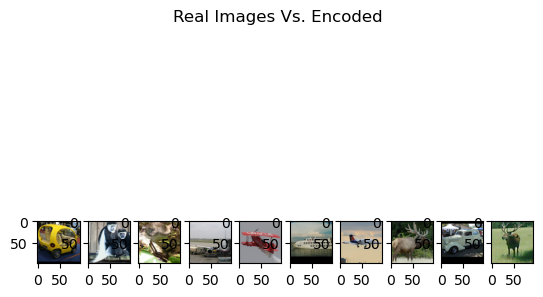

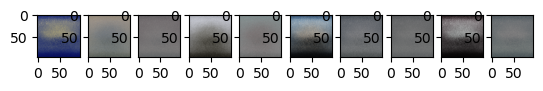

In [9]:
# testing our simple encoder!
fig,axs = plt.subplots(1,10) # 4 size subplot
fig.suptitle("Real Images Vs. Encoded")
for i in range(10):
    axs[i].imshow(imgs_show[i+100])

fig2,axs2 = plt.subplots(1,10) # 4 size subplot
for i in range(10):
    img = images[i+100].to(device).view(1,3,D1,D2)
    img = model(img).view(3,D1,D2).permute(1,2,0).detach().to('cpu').numpy()
    axs2[i%10].imshow(img)

## Lets try to explain what happened here

### Encoder/Decoder architecture:
- We tried to as efficiently as possible compress information down, and then build it up for a large set of images. The model probably did something like: finding overall 'chunks' of the image, encode this into the vector, and then re-create these chunks with the decoder.
- As we can see, it preformed pretty poorly. However, we can expect this from a shallow multi-layer perceptron, and we adress the issue of representational capability by building a deeper conv-net architecture

* Note: later we will go into why this cannot be used for generation

Ok, we got something out of this, but we could do much, much better by exploiting the properties of images
by using convolutions.

> Convolutions are more computationally efficient and accurate, because they take advantage of the spacial nature of images

> Ideally, our encoder would be able to abstractly define our image in a few latent-space variables, and reproduce a great copy of them.
>
> If you think about this, a pretrained LLM would be great: distilling the information into a complex latent space (tokens) and being able to re-describe this. However, this is *far* beyond our simple 3 layer MLP which can only represent simple concepts

# Conv Net Implementation
Before we implement our convolutional NN, lets get a simple view of what they do:

## Convolutions
- Each part of a convolutional layer has 'kernels', which 'scan' over the entire image in steps with the same set of weights, indentifying certain features
- we can have a kernel detecting edges, or really any feature
- Each part of the kernel has a bias so we can represent the rarity of there being certain features at certain areas


> Note: every convolutional layer after the first one has each kernel scan seperate feature maps. So we would have (prevfeaturemaps)*(kernelsperprev) kernels.

## pooling
- After we do convolutions, we another kernel (NxN) and slide it across the output of the previous kernel. 
- Each NxN chunk of the previous kernel is either averaged or, we take the max and only save that value.
- This is to reduce dimensionality and only save the 'essential' parts of our kernels
- Kernels will have to learn with this pooling in mind (need to be more general)


## Overall result
- Kernels increase in the amount of information they extract, with a high amount of kernels, but with low amount of spatial data. This means we have a lot of low-dimensional, information-dense representations that are more suitable to feed to a multi-layer pereceptron/classifier/encoder.
- We trade position for information about the nature of an image
- Each convolution will have scanned, and distilled the whole image into a low-dimensional representation

Here is my simple visualization of a Conv net:
![ConvNet Viz](convnet.png)

> Notes on kernel parameters:
>
>- Padding is when we 'pad' the outside of an image with empty pixels, so we can effectively hit each part of our image with each weight (some edge parts won't be multiplied with some weights)
>
>- Strides are how much we 'jump' between chunks of our image, the more strides, the more data that is lost. We are able to stride because, every single region of our image doesn't necessarily need to be scanned for every feature (image regions will share features)

## Decoder Layer
Ok, so we can use a conv. net 'feature extractor' to feed to our neural network data and extract features. 

***But how do we decode our convolutions?***

1. We have our 'inverse' MLP which is simple enough, and just maps a lower-dimensional latent vector to a higher dimensional space.
2. We can translate the 'last' MLP decoder to the first kernels in decoder (last in encoder)
3. Then, for each succesive convolutional layer, we run convolutions on these layers, and if there are multiple kernels for a previous one, we would sum these kernels together.

We are basically trying to re-create convolutions from lower-dimensional ones, with learned output. For example, if a lower-dimensional convolution has signs of a feature, a higher dimensional convolution (early layer in encoder) will interpolate what these features mean in respect to the original image, and try to fit them in the best spot possible (with learned parameters).

Here is a quick visualization:
![deconv](deconvolution.png)

There are different structures for the transposed convolution based on strides or no strides, but the basic picture is that we are trying to learn to recreate orginal higher dimensional pixels by mapping a lower dimensional feature map with learned weights (and making sure that our pixels allign to the original feature maps that sumed them). The exact shapes are not important, as pytorch handles this for us.

> Note
>
> If we have multiple kernels created from one previous one in the encoder, we just do our reverse-convolution, and sum them up in our next layer.

Lets implement this and create a new, more powerful, autoencoder.

In [10]:
D1 = 96
D2 = 96 # dimensionality of data
import torch.nn as nn

# because maxpool2d can't deal with some shapes
# we need to specify indices

# creating the MLP autoencoder
class AutoencoderCNN(nn.Module):
    def __init__(self):
        super(AutoencoderCNN, self).__init__()
        # data is B,3,D1,D2 (B,Color,Pixels)
        
        '''     
        * conv2d takes: nin,nout (kernels),
        kernel size^2, padding,stride
        
        * taking maxpool, means we are taking the
        maximum value in our 'scan', and writing this
        to new lower-dim kernel
        
        * Each kernel has sub-kernels, which are used for 
        each seperate kernel, and then summed
        
        '''
        # encoder
       
        # 3 channels for color
        # Batch, Channel, W,H --> channel treated as same input
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3,9,3,stride=2,padding=1,groups=3), # 6, 48x48 kernels
            nn.ReLU(),
            # each kernel contains 3 'sub kernels' for each 
            # prev. feature map. 
            nn.Conv2d(9,3,3,stride=2,padding=1,groups=3),# 3, 13x13 kernels
            nn.ReLU(),
            
            nn.Conv2d(3,3,3,stride=2,padding=1,groups=3),# 3, 6x6 kernels
            nn.ReLU(),
        
        )
        
        self.encoder_lin = nn.Sequential(
            
            # mlp
            nn.Linear(144,110),
            nn.ReLU(),
            nn.Linear(110,64),
            nn.ReLU()
        )



        # reverse of encoder
        # decoder
        # reverse order to map to shape
        self.decoder_lin = nn.Sequential(
            nn.Linear(64,110),
            nn.ReLU(),
            nn.Linear(110,144),
            nn.ReLU(),
    )
        self.decoder_conv = nn.Sequential (
            # unpool layer takes reverse of previous
            # indices and unpools
            # reverse of our convolution
            nn.ConvTranspose2d(3,3,3,stride=2,padding=1,groups=3,output_padding=1), # 3
            nn.ReLU(), # activation function to learn/symmetry
            nn.ConvTranspose2d(3,9,3,stride=2,padding=1,groups=3,output_padding=1), # 3
            nn.ReLU(), # activation function to learn/symmetry
            nn.ConvTranspose2d(9,3,3,stride=2,padding=1,groups=3,output_padding=1),

            nn.Sigmoid() # for pixel values
            )
        
    def decode(self,x):
        # decoder portion
        x = self.decoder_lin(x)
        x = x.view(int(x.shape[0]),3,12,12)
        x = self.decoder_conv(x)
        
        return x



    def forward(self,x):
        # -----------------------
        # encoder 
        x = self.encoder_conv(x)
        x = x.view(x.shape[0],3,12*12)
        x = self.encoder_lin(x)
        
        
        # decoder
        x = self.decoder_lin(x)
        x = x.view(int(x.shape[0]),3,12,12)
        x = self.decoder_conv(x)
        

        return x
    
    
model = AutoencoderCNN()
device = 'cuda'
model.to(device) # putting in gpu
# adamW with smaller weight-decay
optimizer = torch.optim.Adam(model.parameters(),lr=2e-3,weight_decay=1e-6) 
mse_loss = nn.MSELoss()


In [11]:
# training loop
# comparing actual image construction
# with our bottleneck, and training our model
# to learn to reconstruct and build this latent-space
# representation

def get_batch(data,size):
    # return size,3,h*w batches of data
    # data is list of tensors
    ind = torch.randint(0,len(data),size=(size,),device=device).tolist()
    batch = torch.stack([data[i] for i in ind]).to(device=device)
    return batch.view(size,3,D1,D2).to(device)

# calculating loss with our image
def calculate_loss(og,reconstr):
    # flatten both tensors and avg 
    # squared difference between pixel vals!
    size = og.view(-1).shape[0]
    squared_error = ((og.view(-1)-reconstr.view(-1))**2).sum()
    mse = squared_error/size
    return mse
    

for i in range(5000):
    # feeding batch into model
    batch = get_batch(images,100)
    reconstruction = model(batch)
    # calculate loss based on original and reconstruction
    loss = calculate_loss(batch,reconstruction)

    # backward pass and automatic optimization!
    if i % 100 == 0:
        print(round(loss.item(),4), i)
    optimizer.zero_grad() # set grads to zero
    loss.backward()
    optimizer.step()



0.0766 0
0.0705 100
0.0663 200
0.068 300
0.0616 400
0.0621 500
0.0565 600
0.068 700
0.061 800
0.0619 900
0.0604 1000
0.0596 1100
0.0606 1200
0.0597 1300
0.0599 1400
0.0608 1500
0.0587 1600
0.0597 1700
0.0607 1800
0.0591 1900
0.058 2000
0.0604 2100
0.0601 2200
0.0572 2300
0.058 2400
0.0545 2500
0.0568 2600
0.0523 2700
0.0586 2800
0.0546 2900
0.057 3000
0.0557 3100
0.0554 3200
0.0575 3300
0.0529 3400
0.0549 3500
0.0538 3600
0.0546 3700
0.0557 3800
0.0555 3900
0.0543 4000
0.0537 4100
0.0569 4200
0.0555 4300
0.0531 4400
0.0571 4500
0.0524 4600
0.0522 4700
0.0552 4800
0.0521 4900


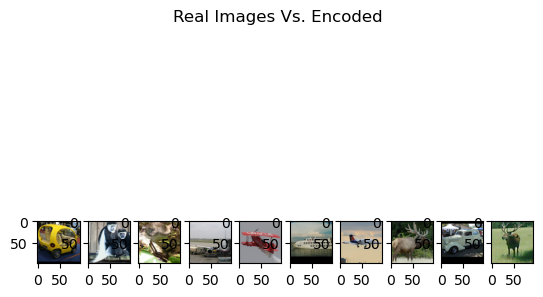

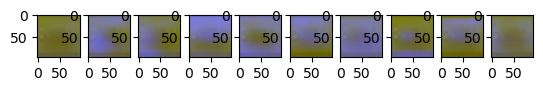

In [12]:
# testing our simple encoder!
# same shapes passed in as before
fig,axs = plt.subplots(1,10) # 4 size subplot
fig.suptitle("Real Images Vs. Encoded")
for i in range(10):
    axs[i].imshow(imgs_show[i+100])

fig2,axs2 = plt.subplots(1,10) # 4 size subplot
for i in range(10):
    img = images[i+100].to(device).view(1,3,D1,D2)
    img = model(img).view(3,D1,D2).permute(1,2,0).detach().to('cpu').numpy()
    axs2[i%10].imshow(img)

Results:

Ok, so our results where... worse with the conv. net.

I'm pretty sure this just comes down to engineering our system: which is really besides the point, but we impleneted an autoencoder that can compress, and reconstruct images from just 64 latent-variables.


# Image Generation

Now, how would we generate new images? Well, we would basically just have to plug in random latent-vectors to see what we get, or a vector that is similar to our images.



# Variational Autoencoders

- With variational autoencoders instead of learning a simple latent compression x-->z, we learn q(z|X), or the probability of each latent-variable given our input. We learn this mapping, and then sample from our distribution a value of *z* to get our reconstruction of x

![latent-space](probz.png)

- We learn a mean and std. dev. vector for each *x* sample for our q(z|x)

- They key point of our variational auto-encoder is that we encourage our latent space to be normally distributed by adding a penalty term for how much our q(z|x) differs from a gaussian normal distribution

Then, we simple find the loss, backpropogate, and boom! We now have a structured normal latent space where sampling close to zero gives us a more likely probability, and changing different latent variables could potentially correspond to different distinct changes in our image.

        Example: If 'dog' and 'cat' show up a lot in our dataset with many other images, it may help for them to overlap more, and they likely have more high-level features (extracted by our neural net), and therefore could benefit from a similar latent distribution.

        Therefore we can imagine different latent variables would correspond to different distinct features, and that similar images would be grouped closely together.

our loss function (to maximize) is specifically this: 
![loss-elbo](ELBOLOSS.png)

which comes from trying to both minimize the KL divergence between our normal distribution and q, and also the probability we assign to a real image.

> I like to think of this in probabilistic terms: if we maximize the log likelihood of our given datapoints, if our data is representative of our population (the world), we will maximize the likelihood of relevant datapoints, and in doing so, learn about what is probabilstic in our world (and in turn learning latent variables that describe images)
>
> Then, we will be able to sample from this in our latent space which is really exciting!


## Go to [VAE-with-mnist](MNISTVAE.ipynb) to see implementation of VAE